In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
import dLux.utils as dlu

cmap = plt.get_cmap('inferno')
cmap.set_bad('k')

import warnings; warnings.simplefilter('ignore')


You will have used `bash ../data/MAST_2024-07-03T0023` to download the datasets - this should create a directory `..data/MAST_2024-07-03T0023/HST/` with many subdirectories, each of which contains a dataset. Let's explore one of these.

In [128]:
ddir = '../data/MAST_2024-07-03T0023-1/'
fname = ddir + 'HST/n8yj27020/n8yj27020_mos.fits'
#fname = ddir + 'HST/n8yj65010/n8yj65010_mos.fits'
fname = ddir + 'HST/n9nk01010/n9nk01010_mos.fits'

# n8yj: 2 3 ~6 ~27 38 ~40 ~49 ~~56 65
# n9nk: 1 ~~4 ~5 14 ~~15

# 16 is good binary

prog = 'n8yj'#'n9nk'#'n8yj'

num = 65#65

wv = '2'

fname = ddir + f'HST/{prog}{num:02}0{wv}0/{prog}{num:02}0{wv}0_mos.fits'

ddir = '../data/MAST_2024-07-07T03_17_36.223Z/'
fname = ddir + 'HST/n8ku01050_mos.fits'

#ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
#fname = ddir + 'HST/N43C02020/n43c02020_mos.fits'

ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
fname = ddir + 'HST/N43C03020/n43c03020_mos.fits'
fname = ddir + 'HST/N43CA5010/n43ca5010_mos.fits'

ddir = '../data/MAST_2024-07-07T03_17_36.223Z/'
fname = ddir + 'HST/n8ku01050_mos.fits'

ddir = "../data/MAST_2025-03-06T11_16_44.723Z/HST/"
fname = ddir + 'n6nd12goq_cal.fits'
fname = ddir + 'n6nd12h0q_cal.fits'


data = fits.getdata(fname, ext=1)
data.shape
print(np.max(data))

err = fits.getdata(fname, ext=2)
print(np.max(err))

info = fits.getdata(fname, ext=3)

bad = np.asarray((err==0.0) | (info&256) | (info&64) | (info&32))

959.83655
100000.0


In [129]:
data.flatten()

array([ 0.19613922, -0.9171024 , -0.80676746, ...,  9.33991   ,
        9.920365  ,  5.8723345 ], dtype='>f4')

(array([7.000e+00, 1.800e+01, 1.210e+02, 4.120e+02, 8.850e+02, 1.707e+03,
        2.391e+03, 2.859e+03, 3.044e+03, 3.150e+03, 3.164e+03, 3.488e+03,
        3.882e+03, 4.280e+03, 4.714e+03, 5.055e+03, 4.779e+03, 4.181e+03,
        3.323e+03, 2.386e+03, 1.789e+03, 1.382e+03, 1.125e+03, 9.420e+02,
        7.010e+02, 5.850e+02, 5.000e+02, 4.600e+02, 3.800e+02, 3.870e+02,
        3.210e+02, 3.130e+02, 2.650e+02, 2.210e+02, 2.020e+02, 1.770e+02,
        1.530e+02, 1.260e+02, 1.230e+02, 1.230e+02, 1.190e+02, 1.040e+02,
        8.600e+01, 7.700e+01, 8.900e+01, 8.500e+01, 8.500e+01, 7.100e+01,
        7.400e+01, 5.600e+01, 4.300e+01, 4.100e+01, 2.000e+01, 1.900e+01,
        1.400e+01, 2.000e+01, 2.200e+01, 1.400e+01, 1.300e+01, 1.600e+01,
        1.500e+01, 9.000e+00, 6.000e+00, 3.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 2.830e+02, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+0

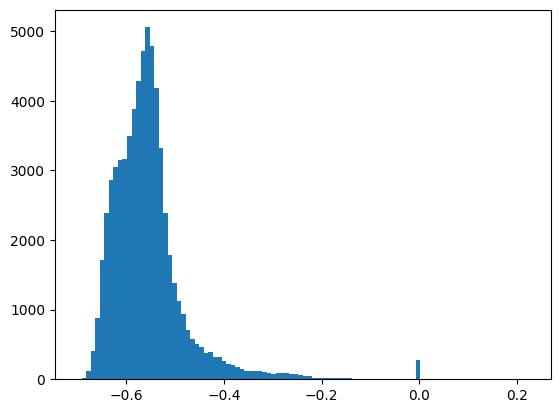

In [130]:
err = np.where(bad, 1, np.asarray(err, dtype=float))
data = np.where(bad, 1, np.asarray(data, dtype=float))
plt.hist(np.log10(err.flatten()), bins=100)

In [131]:
#plt.hist(np.log10((data/err).flatten()), bins=100)

In [132]:
hdul =fits.open(fname)
hdul.info()
hdul.close()

Filename: ../data/MAST_2025-03-06T11_16_44.723Z/HST/n6nd12h0q_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     308   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   


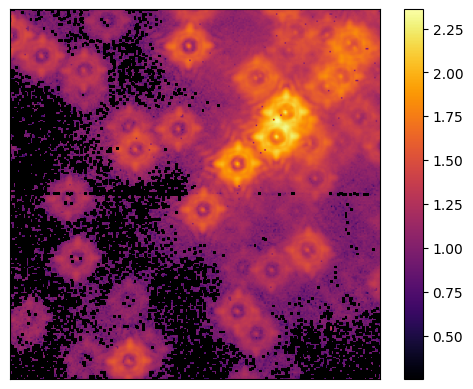

In [146]:
plt.imshow(data**0.125,cmap=cmap,origin='lower')
plt.xticks([])
plt.yticks([])
plt.colorbar()


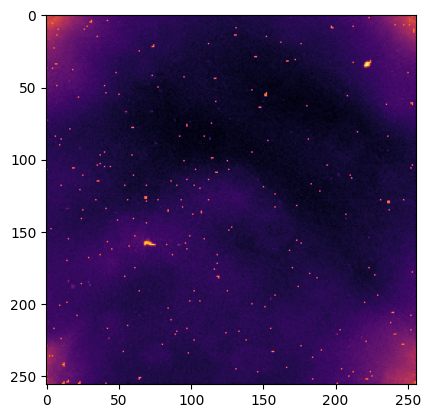

In [134]:
plt.imshow(err**0.125,cmap=cmap)

In [135]:
hdr = fits.getheader(fname, ext=0) # this is the overall header - with lots of metadata
print(hdr)

SIMPLE  =                    T / Fits standard                                  BITPIX  =                   16 / Bits per pixel                                 NAXIS   =                    0 / Number of axes                                 EXTEND  =                    T / File may contain extensions                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        IRAF-TLM= '20:01:20 (24/10/2009)' / Time of last modification                   NEXTEND =                    5 / Number of standard extensions                  DATE    = '2009-10-24T20:01:20' / date this file was written (yyyy-mm-dd)       FILENAME= 'n6nd12h0q_cal.fits' / name of file                                   FILETYPE= 'SCI      '          / type of data found in data file                                                                                                TELESCOP= 'HST'                / telescope used to acquire data                 INSTRUME= 'NICMOS'             / identif

In [136]:
metadata = { # this is the main subset of metadata we care about from the header 
    'tel'    : hdr['TELESCOP'],         # telescope - should be HST
    'fname'  : hdr['FILENAME'],         # original file name
    'ap'     : hdr['APERTURE'],
    'odate'  : hdr['DATE-OBS'],         # UTC date of observation
    'otime'  : hdr['TIME-OBS'],         # UTC time of observation
    'tint'   : hdr['EXPTIME' ],         # integration time (sec)
    'filter' : hdr['FILTER'],           # filter name - should be F110W, or F170W
    'RA'     : hdr['RA_TARG' ],         # right ascension (deg)
    'DEC'    : hdr['DEC_TARG'],         # declination (deg)
    'wavel' : hdr['PHOTPLAM']*1e-10, # central wavelength (meters)
    'orient' : hdr['ORIENTAT'] # P.A. of image y axis (deg e. of n.)
    }

print(metadata)

{'tel': 'HST', 'fname': 'n6nd12h0q_cal.fits', 'ap': 'NIC1-FIX', 'odate': '2002-08-26', 'otime': '21:06:22', 'tint': 9.971616, 'filter': 'F110M', 'RA': 168.783125, 'DEC': -61.26056388889, 'wavel': 1.10179e-06, 'orient': -58.6195}


In [137]:
image_hdr = fits.getheader(fname, ext=1) # this is the header for just the image in particular

# rather than manipulate WCS coordinates ourselves, can use https://docs.astropy.org/en/stable/wcs/
w = WCS(image_hdr)

In [138]:
w.wcs.print_contents()

       flag: 137
      naxis: 2
      crpix: 0x16cb4c410
               128.00       128.00    
         pc: 0x16cb4dd70
    pc[0][]:  -6.2554e-06  -1.0239e-05
    pc[1][]:  -1.0256e-05   6.2450e-06
      cdelt: 0x16cb41cc0
               1.0000       1.0000    
      crval: 0x16cb41cd0
               168.76      -61.255    
      cunit: 0x16cb51a50
             "deg"
             "deg"
      ctype: 0x16cb4e530
             "RA---TAN"
             "DEC--TAN"
    lonpole: 180.000000
    latpole: -61.255218
    restfrq: 0.000000
    restwav: 0.000000
        npv: 0
     npvmax: 0
         pv: 0x0
        nps: 0
     npsmax: 0
         ps: 0x0
         cd: 0x16cb516f0
    cd[0][]:  -6.2554e-06  -1.0239e-05
    cd[1][]:  -1.0256e-05   6.2450e-06
      crota: 0x16cb2e6a0
               0.0000       0.0000    
     altlin: 2
     velref: 0
        alt: ' '
     colnum: 0
      colax: 0x16cb2e6b0
                 0      0
      cname: 0x16cb4e5c0
             UNDEFINED
             UNDEFINED


In [139]:
w.proj_plane_pixel_scales()
dlu.deg2arcsec(1.19930916e-05)

0.04317512976

In [147]:
print(w.pixel_to_world_values(128,128))

(array(168.76484014), array(-61.25522248))


Let's crop this to something more manageable in size.

(30, 30)


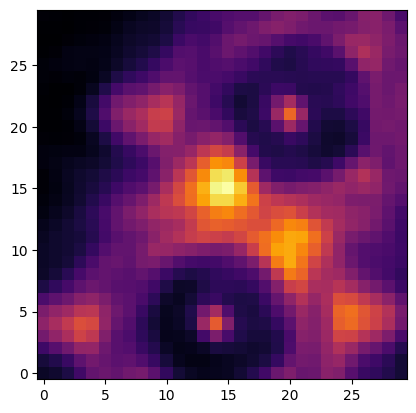

In [141]:
# get brightest pixel coordinates
y,x = np.unravel_index(np.argmax(data),data.shape)
centre = SkyCoord(w.pixel_to_world(x,y), unit='deg') # astropy wants to keep track of units


# use fits_cut because we want WCS metadata cropped appropriately
cutout = fits_cut(fname, centre, 30, single_outfile=False, memory_only=True)[0] 
cropped = cutout[1].data
cropped_image_hdr = cutout[1].header

print(cropped.shape)
plt.imshow(cropped,cmap=cmap,origin='lower');

In [142]:
cutout.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   ()      
  1  CUTOUT        1 ImageHDU       141   (30, 30)   float32   


In [143]:
import glob

In [144]:
file = glob.glob("../data/MAST_2024-09-22T03_37_01.724Z/HST/*_asc.fits")[0]

hdul =fits.open(file)
hdul.info()
hdul.close()

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj23020_asc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   ()      
  1  ASC           1 BinTableHDU     47   3R x 7C   [14A, 14A, 1L, 1L, 1E, 1E, 1E]   


In [145]:
[x[0]+"_cal.fits" for x in fits.getdata(file, ext=1)[0:2]]

['n8yj23jqq_cal.fits', 'n8yj23jsq_cal.fits']